In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
start_year = 2014
end_year = 2024

# load and concat WRDS data for all years
wrds_data = []
for year in range(start_year, end_year + 1):
    df_year = pd.read_csv(f'Data/sp500_cleaned_{year}.csv')
    wrds_data.append(df_year)

wrds_file = pd.concat(wrds_data, ignore_index=True)
# drop columns with nan values
wrds_file = wrds_file.dropna(axis=1)
wrds_file["date"] = pd.to_datetime(wrds_file["date"])

cols_to_drop = set()
# all 6m return columns
for col in wrds_file.columns:
    if '6' in col or "SMA" in col:
        cols_to_drop.add(col)

cols_to_drop.add('ret_3m')
cols_to_drop.add('ret_6m')
wrds_file.drop(columns=list(cols_to_drop), inplace=True)
spy = pd.read_csv('Data/SPY.csv') # Date, SPY
spy["Date"] = pd.to_datetime(spy["Date"])
spy["market_ret"] = spy["SPY"].pct_change()
spy.rename(columns={"Date": "date"}, inplace=True) # rename Date to date for merging
spy = spy[['date', 'market_ret']].dropna()
wrds_file = wrds_file.merge(spy, on='date', how='left')
df = wrds_file.copy()
df.columns

Index(['date', 'ticker', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi',
       'ps', 'pcf', 'dpr', 'npm', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'debt_at',
       'debt_ebitda', 'short_debt', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'at_turn', 'rect_turn', 'pay_turn', 'sale_equity', 'rd_sale',
       'adv_sale', 'staff_sale', 'accrual', 'ptb', 'divyield', 'volume',
       'price', 'ret_1m', 'vol_3m', 'EMA_3', 'RVOL_3', 'vol_ROC', 'vol_mom',
       'market_ret'],
      dtype='object')

Total factors to test: 55
Data shape: (52162, 59)
Date range: 2014-01-31 00:00:00 to 2024-12-31 00:00:00

Train: (42059, 59) (2014-01-31 00:00:00 to 2022-12-31 00:00:00)
Test: (10537, 59) (2022-12-31 00:00:00 to 2024-12-31 00:00:00)

Risk-free rate: 0.287% monthly (3.5% annual)

TESTING ALL FACTORS INDIVIDUALLY

Testing 55 factors × 4 strategies × 3 sizes
Total combinations: 660
Progress: 20/660 (3.0%)
Progress: 40/660 (6.1%)
Progress: 60/660 (9.1%)
Progress: 80/660 (12.1%)
Progress: 100/660 (15.2%)
Progress: 120/660 (18.2%)
Progress: 140/660 (21.2%)
Progress: 160/660 (24.2%)
Progress: 180/660 (27.3%)
Progress: 200/660 (30.3%)
Progress: 220/660 (33.3%)
Progress: 240/660 (36.4%)
Progress: 260/660 (39.4%)
Progress: 280/660 (42.4%)
Progress: 300/660 (45.5%)
Progress: 320/660 (48.5%)
Progress: 340/660 (51.5%)
Progress: 360/660 (54.5%)
Progress: 380/660 (57.6%)
Progress: 400/660 (60.6%)
Progress: 420/660 (63.6%)
Progress: 440/660 (66.7%)
Progress: 460/660 (69.7%)
Progress: 480/660 (72.7%)
P

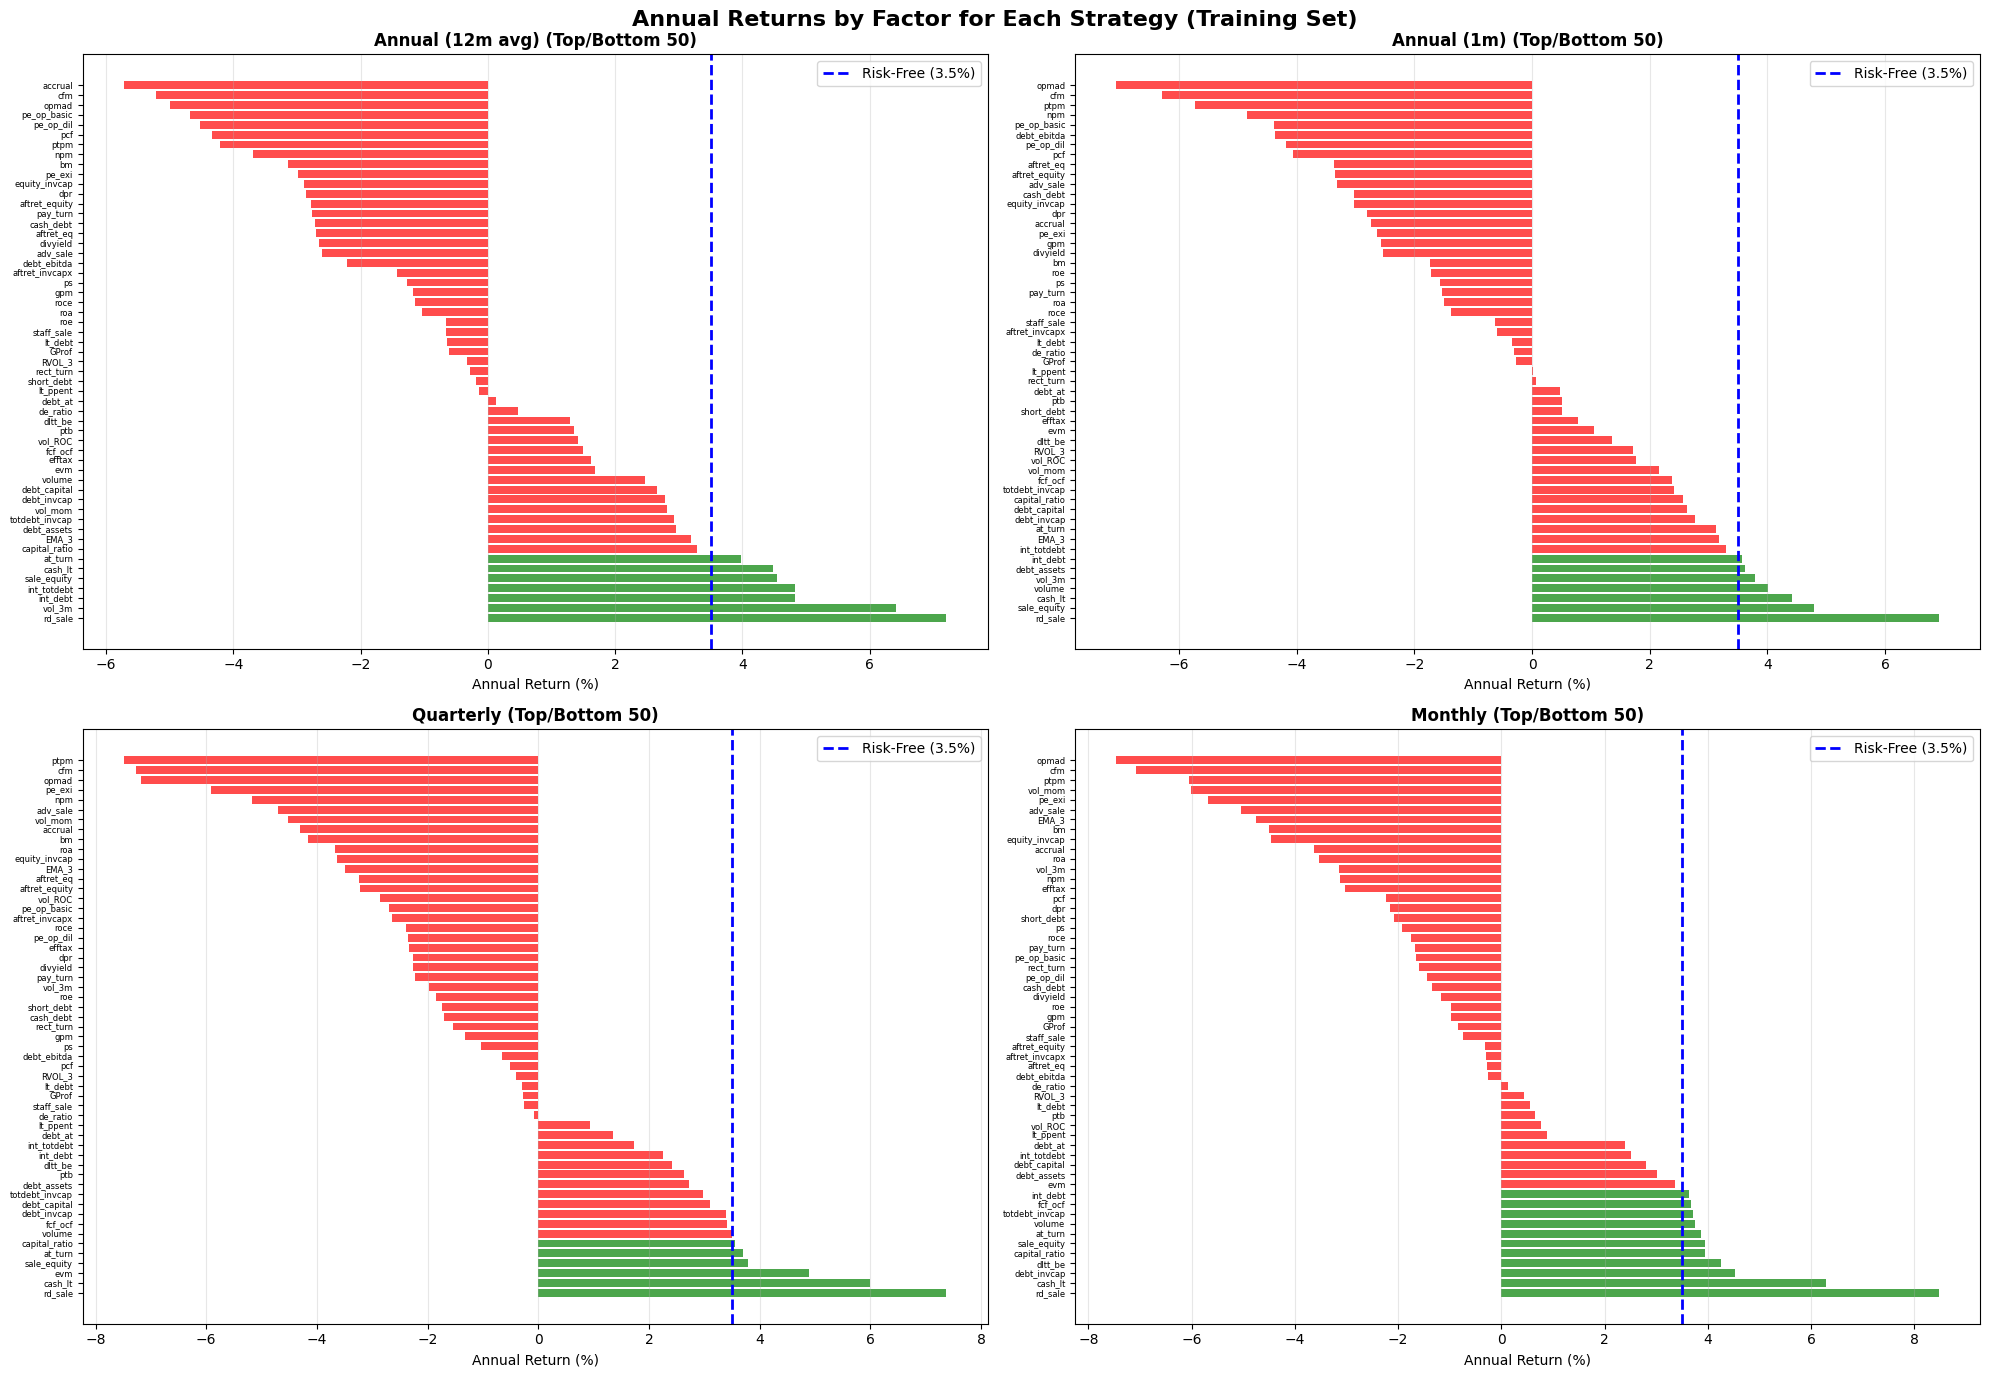


GENERATING SUMMARY HEATMAP


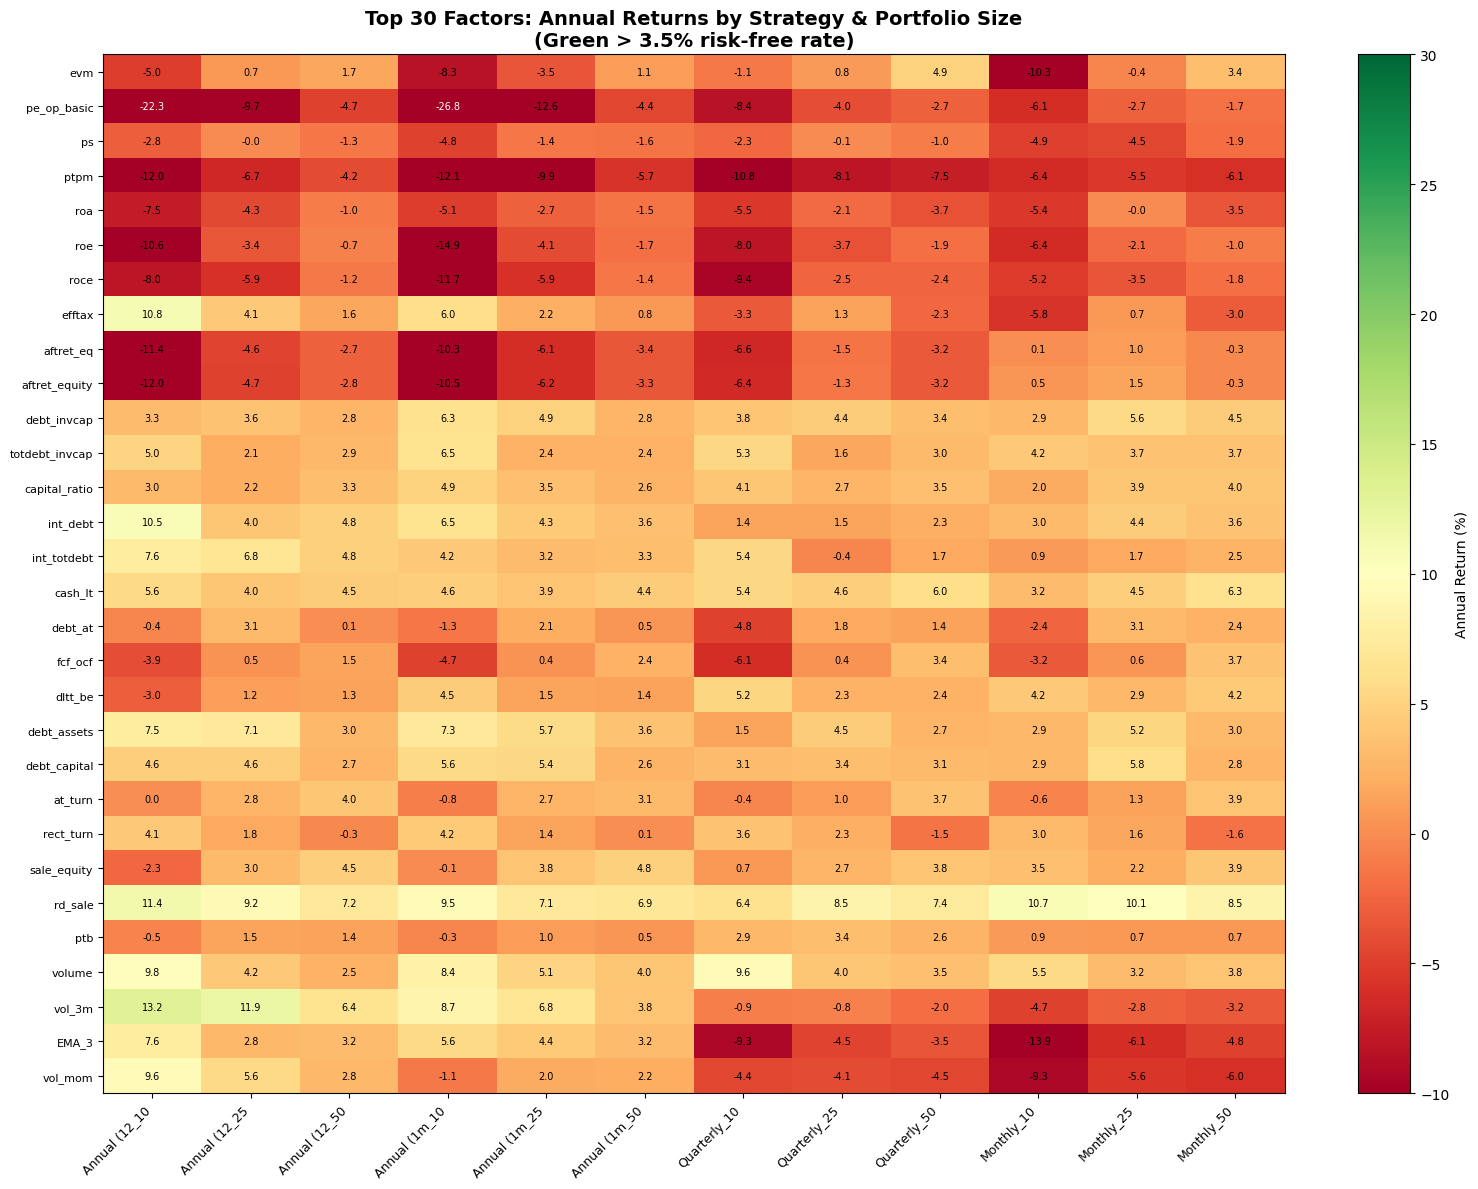


FACTOR SELECTION RESULTS

Factors beating risk-free rate in at least 6 out of 12 tests:
Total selected: 10

Selected factors: ['rd_sale', 'cash_lt', 'volume', 'int_debt', 'debt_assets', 'debt_invcap', 'vol_3m', 'totdebt_invcap', 'sale_equity', 'capital_ratio']

EXPORTING DETAILED RESULTS

Results saved to:
  - results_df: Detailed results for all factor/strategy/size combinations
  - factor_performance: Summary statistics by factor
  - selected_factors: List of 10 factors that consistently beat risk-free rate

✅ Individual factor analysis complete!

Key findings:
  - Tested 55 factors
  - 10 factors beat risk-free rate consistently
  - Risk-free rate threshold: 3.5% annual


In [ ]:
# ========================================
# INDIVIDUAL FACTOR TESTING STRATEGY
# Testing each factor independently with different rebalancing frequencies
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# ========================================
# DATA PREPARATION
# ========================================

df = wrds_file.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'ticker'])

# Drop price column if it exists
if 'price' in df.columns:
    df = df.drop(columns=['price'])

# Identify factor columns
factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

print(f"Total factors to test: {len(factor_cols)}")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Split data
train_start = "2014-01-01"
test_start = "2022-12-31"
test_end = "2024-12-31"

train = df[(df['date'] >= train_start) & (df['date'] <= test_start)]
test = df[(df['date'] >= test_start) & (df['date'] <= test_end)]

print(f"\nTrain: {train.shape} ({train['date'].min()} to {train['date'].max()})")
print(f"Test: {test.shape} ({test['date'].min()} to {test['date'].max()})")

# ========================================
# RISK-FREE RATE
# ========================================
risk_free_annual = 0.035  # 3.5% annual as per paper
risk_free_monthly = (1 + risk_free_annual)**(1/12) - 1
print(f"\nRisk-free rate: {risk_free_monthly*100:.3f}% monthly ({risk_free_annual*100:.1f}% annual)")

# ========================================
# STRATEGY IMPLEMENTATION
# ========================================

def calculate_factor_average(data, factor, ticker, current_date, n_months=12):
    """
    Calculate average factor value over past n months for a stock
    """
    past_data = data[(data['ticker'] == ticker) & 
                     (data['date'] > current_date - pd.DateOffset(months=n_months)) &
                     (data['date'] <= current_date)]
    
    if len(past_data) == 0:
        return np.nan
    
    return past_data[factor].mean()

def build_single_factor_portfolio(data, factor, strategy='monthly', n_long=50, n_short=50):
    """
    Build portfolio based on a single factor
    
    Parameters:
    -----------
    data : DataFrame
        Data to trade on
    factor : str
        Factor column name
    strategy : str
        'annual_12m', 'annual_1m', 'quarterly', 'monthly'
    n_long : int
        Number of stocks to long
    n_short : int
        Number of stocks to short
    
    Returns:
    --------
    DataFrame with portfolio returns
    """
    
    all_dates = sorted(data['date'].unique())
    portfolio_returns = []
    
    current_long_tickers = None
    current_short_tickers = None
    months_since_rebalance = 0
    
    for i in range(len(all_dates) - 1):
        current_date = all_dates[i]
        next_date = all_dates[i + 1]
        
        # Determine if we should rebalance
        should_rebalance = False
        
        if strategy == 'monthly':
            should_rebalance = True
            
        elif strategy == 'quarterly':
            # Rebalance in Jan, Apr, Jul, Oct
            if current_date.month in [1, 4, 7, 10] and months_since_rebalance >= 3:
                should_rebalance = True
            elif current_long_tickers is None:
                should_rebalance = True
                
        elif strategy in ['annual_12m', 'annual_1m']:
            # Rebalance in January
            if current_date.month == 1 and months_since_rebalance >= 12:
                should_rebalance = True
            elif current_long_tickers is None:
                should_rebalance = True
        
        # REBALANCING
        if should_rebalance:
            grp_current = data[data['date'] == current_date].copy()
            
            # Calculate factor values based on strategy
            if strategy == 'annual_12m':
                # Use 12-month average
                grp_current['factor_value'] = grp_current.apply(
                    lambda row: calculate_factor_average(data, factor, row['ticker'], current_date, n_months=12),
                    axis=1
                )
            else:
                # Use previous month value (current month for all other strategies)
                grp_current['factor_value'] = grp_current[factor]
            
            # Remove stocks with missing factor values
            grp_current = grp_current.dropna(subset=['factor_value'])
            
            if len(grp_current) < (n_long + n_short):
                months_since_rebalance += 1
                continue
            
            # Rank by factor value
            grp_current = grp_current.sort_values('factor_value', ascending=False)
            
            # Select top n_long and bottom n_short
            current_long_tickers = grp_current.head(n_long)['ticker'].tolist()
            current_short_tickers = grp_current.tail(n_short)['ticker'].tolist()
            
            months_since_rebalance = 0
        
        # MEASURE RETURNS
        if current_long_tickers is None or current_short_tickers is None:
            months_since_rebalance += 1
            continue
        
        grp_next = data[data['date'] == next_date].copy()
        
        # Get returns for long and short positions
        long_rets = grp_next[grp_next['ticker'].isin(current_long_tickers)]['ret_1m']
        short_rets = grp_next[grp_next['ticker'].isin(current_short_tickers)]['ret_1m']
        
        # Skip if too many stocks dropped out
        if len(long_rets) < n_long // 2 or len(short_rets) < n_short // 2:
            current_long_tickers = None
            current_short_tickers = None
            months_since_rebalance = 0
            continue
        
        # Calculate portfolio returns
        long_ret = long_rets.mean()
        short_ret = short_rets.mean()
        ls_ret = long_ret - short_ret
        
        portfolio_returns.append({
            'date': next_date,
            'formation_date': current_date,
            'long_return': long_ret,
            'short_return': short_ret,
            'ls_return': ls_ret,
            'n_long': len(long_rets),
            'n_short': len(short_rets),
            'rebalanced': should_rebalance
        })
        
        months_since_rebalance += 1
    
    return pd.DataFrame(portfolio_returns)

def calculate_portfolio_metrics(portfolio_df, risk_free_monthly):
    """
    Calculate performance metrics for a portfolio
    """
    if len(portfolio_df) == 0:
        return None
    
    # Total return
    cum_return = (1 + portfolio_df['ls_return']).prod() - 1
    
    # Annualized return
    n_months = len(portfolio_df)
    n_years = n_months / 12
    if n_years > 0:
        annual_return = (1 + cum_return)**(1/n_years) - 1
    else:
        annual_return = 0
    
    # Volatility
    annual_vol = portfolio_df['ls_return'].std() * np.sqrt(12)
    
    # Sharpe ratio
    excess_returns = portfolio_df['ls_return'] - risk_free_monthly
    if annual_vol > 0:
        sharpe = (excess_returns.mean() * 12) / annual_vol
    else:
        sharpe = 0
    
    # Win rate
    win_rate = (portfolio_df['ls_return'] > 0).mean()
    
    # Max drawdown
    cum_values = 100 * (1 + portfolio_df['ls_return']).cumprod()
    running_max = cum_values.expanding().max()
    drawdown = (cum_values - running_max) / running_max
    max_dd = drawdown.min()
    
    return {
        'n_periods': n_months,
        'cum_return': cum_return,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe,
        'win_rate': win_rate,
        'max_drawdown': max_dd
    }

# ========================================
# TEST ALL FACTORS WITH ALL STRATEGIES
# ========================================

print("\n" + "="*60)
print("TESTING ALL FACTORS INDIVIDUALLY")
print("="*60)

strategies = ['annual_12m', 'annual_1m', 'quarterly', 'monthly']
strategy_names = {
    'annual_12m': 'Annual (12m avg)',
    'annual_1m': 'Annual (1m)',
    'quarterly': 'Quarterly',
    'monthly': 'Monthly'
}

portfolio_sizes = [10, 25, 50]

all_results = []

print(f"\nTesting {len(factor_cols)} factors × {len(strategies)} strategies × {len(portfolio_sizes)} sizes")
print(f"Total combinations: {len(factor_cols) * len(strategies) * len(portfolio_sizes)}")

counter = 0
total = len(factor_cols) * len(strategies) * len(portfolio_sizes)

for factor in factor_cols:
    for strategy in strategies:
        for n_stocks in portfolio_sizes:
            counter += 1
            
            if counter % 20 == 0:
                print(f"Progress: {counter}/{total} ({counter/total*100:.1f}%)")
            
            # Build portfolio
            portfolio_df = build_single_factor_portfolio(
                data=train,
                factor=factor,
                strategy=strategy,
                n_long=n_stocks,
                n_short=n_stocks
            )
            
            # Calculate metrics
            metrics = calculate_portfolio_metrics(portfolio_df, risk_free_monthly)
            
            if metrics is not None:
                all_results.append({
                    'factor': factor,
                    'strategy': strategy,
                    'strategy_name': strategy_names[strategy],
                    'n_stocks': n_stocks,
                    'n_periods': metrics['n_periods'],
                    'cum_return': metrics['cum_return'],
                    'annual_return': metrics['annual_return'],
                    'annual_vol': metrics['annual_vol'],
                    'sharpe': metrics['sharpe'],
                    'win_rate': metrics['win_rate'],
                    'max_drawdown': metrics['max_drawdown'],
                    'beats_rf': metrics['annual_return'] > risk_free_annual
                })

results_df = pd.DataFrame(all_results)

print(f"\nCompleted! Generated {len(results_df)} results")

# ========================================
# SUMMARY STATISTICS
# ========================================

print("\n" + "="*60)
print("SUMMARY: FACTORS BEATING RISK-FREE RATE")
print("="*60)

# Count how many times each factor beats risk-free rate
factor_performance = results_df.groupby('factor').agg({
    'beats_rf': 'sum',
    'annual_return': 'mean',
    'sharpe': 'mean'
}).reset_index()

factor_performance.columns = ['factor', 'times_beats_rf', 'avg_annual_return', 'avg_sharpe']
factor_performance = factor_performance.sort_values('times_beats_rf', ascending=False)

print(f"\nTop 20 factors by # times beating risk-free rate (out of {len(strategies) * len(portfolio_sizes)} tests):")
print(factor_performance.head(20).to_string(index=False))

# ========================================
# VISUALIZATIONS
# ========================================

# Plot 1: Returns by factor for each strategy
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

for idx, strategy in enumerate(strategies):
    strategy_data = results_df[results_df['strategy'] == strategy]
    
    # Get data for n_stocks=50 (most stocks)
    plot_data = strategy_data[strategy_data['n_stocks'] == 50].copy()
    plot_data = plot_data.sort_values('annual_return', ascending=False)
    
    # Color bars based on whether they beat risk-free rate
    colors = ['green' if x else 'red' for x in plot_data['beats_rf']]
    
    axes[idx].barh(range(len(plot_data)), plot_data['annual_return'] * 100, color=colors, alpha=0.7)
    axes[idx].axvline(risk_free_annual * 100, color='blue', linestyle='--', linewidth=2, label=f'Risk-Free ({risk_free_annual*100:.1f}%)')
    axes[idx].set_yticks(range(len(plot_data)))
    axes[idx].set_yticklabels(plot_data['factor'], fontsize=6)
    axes[idx].set_xlabel('Annual Return (%)', fontsize=10)
    axes[idx].set_title(f'{strategy_names[strategy]} (Top/Bottom 50)', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.suptitle('Annual Returns by Factor for Each Strategy (Training Set)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 2: Summary heatmap
print("\n" + "="*60)
print("GENERATING SUMMARY HEATMAP")
print("="*60)

# Create summary showing which factors beat RF for each strategy/size combo
summary_data = []

for factor in factor_cols:
    row = {'factor': factor}
    for strategy in strategies:
        for n_stocks in portfolio_sizes:
            key = f"{strategy_names[strategy][:10]}_{n_stocks}"
            subset = results_df[(results_df['factor'] == factor) & 
                              (results_df['strategy'] == strategy) & 
                              (results_df['n_stocks'] == n_stocks)]
            if len(subset) > 0:
                row[key] = subset['annual_return'].values[0] * 100
            else:
                row[key] = np.nan
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Select top 30 factors for visualization
top_factors = factor_performance.head(30)['factor'].tolist()
summary_df_plot = summary_df[summary_df['factor'].isin(top_factors)]

# Create heatmap
fig, ax = plt.subplots(figsize=(16, 12))

data_cols = [c for c in summary_df_plot.columns if c != 'factor']
heatmap_data = summary_df_plot[data_cols].values

im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=-10, vmax=30)

ax.set_xticks(range(len(data_cols)))
ax.set_yticks(range(len(summary_df_plot)))
ax.set_xticklabels(data_cols, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(summary_df_plot['factor'], fontsize=8)

# Add values to cells
for i in range(len(summary_df_plot)):
    for j in range(len(data_cols)):
        value = heatmap_data[i, j]
        if not np.isnan(value):
            color = 'white' if abs(value) > 15 else 'black'
            ax.text(j, i, f'{value:.1f}', ha="center", va="center", color=color, fontsize=7)

plt.colorbar(im, ax=ax, label='Annual Return (%)')
ax.set_title(f'Top 30 Factors: Annual Returns by Strategy & Portfolio Size\n(Green > {risk_free_annual*100:.1f}% risk-free rate)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# FACTOR SELECTION
# ========================================

print("\n" + "="*60)
print("FACTOR SELECTION RESULTS")
print("="*60)

# Select factors that beat risk-free rate in at least 50% of tests
min_successes = len(strategies) * len(portfolio_sizes) * 0.5

selected_factors = factor_performance[factor_performance['times_beats_rf'] >= min_successes]['factor'].tolist()

print(f"\nFactors beating risk-free rate in at least {min_successes:.0f} out of {len(strategies) * len(portfolio_sizes)} tests:")
print(f"Total selected: {len(selected_factors)}")
print(f"\nSelected factors: {selected_factors[:20]}")  # Show first 20

# Export results
print("\n" + "="*60)
print("EXPORTING DETAILED RESULTS")
print("="*60)

# Save to variables for further analysis
print(f"\nResults saved to:")
print(f"  - results_df: Detailed results for all factor/strategy/size combinations")
print(f"  - factor_performance: Summary statistics by factor")
print(f"  - selected_factors: List of {len(selected_factors)} factors that consistently beat risk-free rate")

print("\n✅ Individual factor analysis complete!")
print(f"\nKey findings:")
print(f"  - Tested {len(factor_cols)} factors")
print(f"  - {len(selected_factors)} factors beat risk-free rate consistently")
print(f"  - Risk-free rate threshold: {risk_free_annual*100:.1f}% annual")

In [ ]:
# ========================================
# OPTIMIZED INDIVIDUAL FACTOR TESTING
# Fast implementation with parallel processing
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import warnings
warnings.filterwarnings('ignore')

# ========================================
# DATA PREPARATION
# ========================================

df = wrds_file.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'ticker'])

if 'price' in df.columns:
    df = df.drop(columns=['price'])

factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

print(f"Total factors to test: {len(factor_cols)}")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Split data
train_start = "2014-01-01"
test_start = "2022-12-31"
test_end = "2024-12-31"

train = df[(df['date'] >= train_start) & (df['date'] <= test_start)]
test = df[(df['date'] >= test_start) & (df['date'] <= test_end)]

print(f"\nTrain: {train.shape} ({train['date'].min()} to {train['date'].max()})")
print(f"Test: {test.shape} ({test['date'].min()} to {test['date'].max()})")

# ========================================
# RISK-FREE RATE
# ========================================
risk_free_annual = 0.035
risk_free_monthly = (1 + risk_free_annual)**(1/12) - 1
print(f"\nRisk-free rate: {risk_free_monthly*100:.3f}% monthly ({risk_free_annual*100:.1f}% annual)")

# ========================================
# OPTIMIZED STRATEGY IMPLEMENTATION
# ========================================

def calculate_portfolio_metrics(returns, risk_free_monthly):
    """Calculate all key metrics efficiently"""
    if len(returns) == 0:
        return None
    
    returns = np.array(returns)
    
    # Cumulative return
    cum_return = np.prod(1 + returns) - 1
    
    # Annualized return
    n_months = len(returns)
    n_years = n_months / 12
    annual_return = (1 + cum_return)**(1/n_years) - 1 if n_years > 0 else 0
    
    # Annualized volatility
    annual_vol = np.std(returns, ddof=1) * np.sqrt(12)
    
    # Sharpe ratio
    excess_returns = returns - risk_free_monthly
    sharpe = (np.mean(excess_returns) * 12) / annual_vol if annual_vol > 0 else 0
    
    # Max drawdown
    cum_values = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cum_values)
    drawdown = (cum_values - running_max) / running_max
    max_drawdown = np.min(drawdown)
    
    # Win rate
    win_rate = np.mean(returns > 0)
    
    return {
        'n_periods': n_months,
        'cum_return': cum_return,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate
    }

def build_portfolio_vectorized(data, factor, strategy, n_long, n_short):
    """Vectorized portfolio construction"""
    
    # Pre-sort data
    data = data.sort_values(['date', factor], ascending=[True, False])
    
    all_dates = data['date'].unique()
    portfolio_returns = []
    
    rebalance_months = {
        'monthly': list(range(1, 13)),
        'quarterly': [1, 4, 7, 10],
        'annual_12m': [1],
        'annual_1m': [1]
    }[strategy]
    
    current_long = None
    current_short = None
    last_rebalance = None
    
    for i in range(len(all_dates) - 1):
        curr_date = all_dates[i]
        next_date = all_dates[i + 1]
        
        # Check if we should rebalance
        should_rebalance = (
            current_long is None or
            (curr_date.month in rebalance_months and 
             (last_rebalance is None or 
              (curr_date.year > last_rebalance.year or 
               curr_date.month != last_rebalance.month)))
        )
        
        if should_rebalance:
            curr_data = data[data['date'] == curr_date].copy()
            
            # Handle 12-month average for annual_12m
            if strategy == 'annual_12m':
                lookback = curr_date - pd.DateOffset(months=12)
                historical = data[(data['date'] > lookback) & (data['date'] <= curr_date)]
                factor_avg = historical.groupby('ticker')[factor].mean()
                curr_data = curr_data.set_index('ticker').join(factor_avg, rsuffix='_avg')
                curr_data = curr_data.reset_index()
                curr_data = curr_data.dropna(subset=[factor + '_avg'])
                curr_data = curr_data.sort_values(factor + '_avg', ascending=False)
            else:
                curr_data = curr_data.dropna(subset=[factor])
            
            if len(curr_data) >= (n_long + n_short):
                current_long = set(curr_data.head(n_long)['ticker'])
                current_short = set(curr_data.tail(n_short)['ticker'])
                last_rebalance = curr_date
        
        if current_long is None or current_short is None:
            continue
        
        # Get next period returns
        next_data = data[data['date'] == next_date]
        
        long_rets = next_data[next_data['ticker'].isin(current_long)]['ret_1m']
        short_rets = next_data[next_data['ticker'].isin(current_short)]['ret_1m']
        
        if len(long_rets) >= n_long // 2 and len(short_rets) >= n_short // 2:
            ls_ret = long_rets.mean() - short_rets.mean()
            portfolio_returns.append(ls_ret)
    
    return portfolio_returns

def process_single_combination(args):
    """Process a single factor/strategy/size combination"""
    data, factor, strategy, n_stocks, risk_free_monthly = args
    
    try:
        returns = build_portfolio_vectorized(data, factor, strategy, n_stocks, n_stocks)
        metrics = calculate_portfolio_metrics(returns, risk_free_monthly)
        
        if metrics is not None:
            return {
                'factor': factor,
                'strategy': strategy,
                'n_stocks': n_stocks,
                **metrics,
                'beats_rf': metrics['annual_return'] > risk_free_annual
            }
    except Exception as e:
        print(f"Error with {factor}/{strategy}/{n_stocks}: {e}")
    
    return None

# ========================================
# PARALLEL PROCESSING
# ========================================

print("\n" + "="*60)
print("TESTING ALL FACTORS WITH PARALLEL PROCESSING")
print("="*60)

strategies = ['annual_12m', 'annual_1m', 'quarterly', 'monthly']
strategy_names = {
    'annual_12m': 'Annual (12m avg)',
    'annual_1m': 'Annual (1m)',
    'quarterly': 'Quarterly',
    'monthly': 'Monthly'
}
portfolio_sizes = [10, 25, 50]

# Create all combinations
combinations = [
    (train, factor, strategy, n_stocks, risk_free_monthly)
    for factor in factor_cols
    for strategy in strategies
    for n_stocks in portfolio_sizes
]

print(f"\nTotal combinations to test: {len(combinations)}")
print(f"Using {cpu_count()} CPU cores")

# Process in parallel
with Pool(processes=cpu_count()) as pool:
    results = pool.map(process_single_combination, combinations)

# Filter out None results
all_results = [r for r in results if r is not None]
results_df = pd.DataFrame(all_results)

print(f"\nCompleted! Generated {len(results_df)} valid results")

# ========================================
# KEY METRICS SUMMARY
# ========================================

print("\n" + "="*60)
print("KEY METRICS SUMMARY")
print("="*60)

# Overall statistics
print("\nOverall Performance Metrics:")
print(f"  Average Annual Return:    {results_df['annual_return'].mean()*100:>8.2f}%")
print(f"  Average Annual Volatility: {results_df['annual_vol'].mean()*100:>8.2f}%")
print(f"  Average Sharpe Ratio:     {results_df['sharpe'].mean():>8.2f}")
print(f"  Average Max Drawdown:     {results_df['max_drawdown'].mean()*100:>8.2f}%")
print(f"  Average Win Rate:         {results_df['win_rate'].mean()*100:>8.2f}%")

# Best performers
print("\n" + "="*60)
print("TOP 10 STRATEGIES BY SHARPE RATIO")
print("="*60)

top_sharpe = results_df.nlargest(10, 'sharpe')[
    ['factor', 'strategy', 'n_stocks', 'annual_return', 'annual_vol', 'sharpe', 'max_drawdown']
].copy()
top_sharpe['annual_return'] = top_sharpe['annual_return'] * 100
top_sharpe['annual_vol'] = top_sharpe['annual_vol'] * 100
top_sharpe['max_drawdown'] = top_sharpe['max_drawdown'] * 100

print(top_sharpe.to_string(index=False))

# Best by annual return
print("\n" + "="*60)
print("TOP 10 STRATEGIES BY ANNUAL RETURN")
print("="*60)

top_return = results_df.nlargest(10, 'annual_return')[
    ['factor', 'strategy', 'n_stocks', 'annual_return', 'annual_vol', 'sharpe', 'max_drawdown']
].copy()
top_return['annual_return'] = top_return['annual_return'] * 100
top_return['annual_vol'] = top_return['annual_vol'] * 100
top_return['max_drawdown'] = top_return['max_drawdown'] * 100

print(top_return.to_string(index=False))

# Factor-level performance
print("\n" + "="*60)
print("TOP 20 FACTORS (AVERAGED ACROSS ALL STRATEGIES)")
print("="*60)

factor_summary = results_df.groupby('factor').agg({
    'annual_return': 'mean',
    'annual_vol': 'mean',
    'sharpe': 'mean',
    'max_drawdown': 'mean',
    'beats_rf': 'sum'
}).reset_index()

factor_summary = factor_summary.sort_values('sharpe', ascending=False)
factor_summary_display = factor_summary.head(20).copy()
factor_summary_display['annual_return'] = factor_summary_display['annual_return'] * 100
factor_summary_display['annual_vol'] = factor_summary_display['annual_vol'] * 100
factor_summary_display['max_drawdown'] = factor_summary_display['max_drawdown'] * 100

print(factor_summary_display.to_string(index=False))

# Strategy comparison
print("\n" + "="*60)
print("PERFORMANCE BY STRATEGY")
print("="*60)

strategy_summary = results_df.groupby('strategy').agg({
    'annual_return': 'mean',
    'annual_vol': 'mean',
    'sharpe': 'mean',
    'max_drawdown': 'mean',
    'beats_rf': 'sum'
}).reset_index()

strategy_summary['strategy'] = strategy_summary['strategy'].map(strategy_names)
strategy_summary_display = strategy_summary.copy()
strategy_summary_display['annual_return'] = strategy_summary_display['annual_return'] * 100
strategy_summary_display['annual_vol'] = strategy_summary_display['annual_vol'] * 100
strategy_summary_display['max_drawdown'] = strategy_summary_display['max_drawdown'] * 100

print(strategy_summary_display.to_string(index=False))

# ========================================
# VISUALIZATIONS
# ========================================

# Plot 1: Top factors by Sharpe ratio
fig, ax = plt.subplots(figsize=(14, 10))

top_factors = factor_summary.head(30)
colors = ['green' if x > 0 else 'red' for x in top_factors['sharpe']]

ax.barh(range(len(top_factors)), top_factors['sharpe'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_factors)))
ax.set_yticklabels(top_factors['factor'], fontsize=9)
ax.set_xlabel('Sharpe Ratio', fontsize=11)
ax.set_title('Top 30 Factors by Average Sharpe Ratio (Across All Strategies)', 
             fontsize=13, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Plot 2: Return vs Volatility scatter
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(results_df['annual_vol'] * 100, 
                     results_df['annual_return'] * 100,
                     c=results_df['sharpe'], 
                     cmap='RdYlGn', 
                     alpha=0.6,
                     s=50)

ax.axhline(risk_free_annual * 100, color='blue', linestyle='--', 
           linewidth=2, label=f'Risk-Free ({risk_free_annual*100:.1f}%)')
ax.set_xlabel('Annual Volatility (%)', fontsize=11)
ax.set_ylabel('Annual Return (%)', fontsize=11)
ax.set_title('Risk-Return Profile of All Factor Strategies', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Sharpe Ratio', fontsize=10)

plt.tight_layout()
plt.show()

# Plot 3: Metrics comparison for top factors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_10_factors = factor_summary.head(10)['factor'].tolist()
plot_data = results_df[results_df['factor'].isin(top_10_factors)]

# Annual Return
plot_data.boxplot(column='annual_return', by='factor', ax=axes[0, 0])
axes[0, 0].set_title('Annual Return Distribution')
axes[0, 0].set_ylabel('Annual Return')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].axhline(risk_free_annual, color='red', linestyle='--', alpha=0.5)

# Volatility
plot_data.boxplot(column='annual_vol', by='factor', ax=axes[0, 1])
axes[0, 1].set_title('Annual Volatility Distribution')
axes[0, 1].set_ylabel('Annual Volatility')
axes[0, 1].tick_params(axis='x', rotation=45)

# Sharpe Ratio
plot_data.boxplot(column='sharpe', by='factor', ax=axes[1, 0])
axes[1, 0].set_title('Sharpe Ratio Distribution')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)

# Max Drawdown
plot_data.boxplot(column='max_drawdown', by='factor', ax=axes[1, 1])
axes[1, 1].set_title('Max Drawdown Distribution')
axes[1, 1].set_ylabel('Max Drawdown')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Key Metrics for Top 10 Factors', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ========================================
# FACTOR SELECTION
# ========================================

print("\n" + "="*60)
print("FACTOR SELECTION")
print("="*60)

min_successes = len(strategies) * len(portfolio_sizes) * 0.5
selected_factors = factor_summary[factor_summary['beats_rf'] >= min_successes]['factor'].tolist()

print(f"\nFactors beating risk-free rate in at least {min_successes:.0f} tests:")
print(f"Total selected: {len(selected_factors)}")

print("\n✅ Analysis complete!")
print(f"\nKey findings:")
print(f"  - Tested {len(factor_cols)} factors")
print(f"  - Generated {len(results_df)} strategy combinations")
print(f"  - {len(selected_factors)} factors consistently beat risk-free rate")
print(f"  - Best Sharpe ratio: {results_df['sharpe'].max():.2f}")
print(f"  - Best annual return: {results_df['annual_return'].max()*100:.2f}%")

Total factors to test: 55
Data shape: (52162, 59)
Date range: 2014-01-31 00:00:00 to 2024-12-31 00:00:00

Train: (42059, 59) (2014-01-31 00:00:00 to 2022-12-31 00:00:00)
Test: (10537, 59) (2022-12-31 00:00:00 to 2024-12-31 00:00:00)

Risk-free rate: 0.287% monthly (3.5% annual)

TESTING ALL FACTORS WITH PARALLEL PROCESSING

Total combinations to test: 660
Using 12 CPU cores
